In [1]:
import json
import pprint
import pickle
from math import log

# dataset source
# https://files.pushshift.io/reddit/comments/
pp = pprint.PrettyPrinter(indent=4)

In [2]:
class RedditThread():
    def __init__(self, link):
        self.body = ""
        self.netScore = 0
        self.link = link
        self.numberOfComments = 0

    def update(self, body, score):
        self.netScore += score
        self.body = self.body + " " + body
        self.numberOfComments += 1

    def concat(self, reddit_thread):
        self.netScore += reddit_thread.netScore
        self.body = self.body + " " + reddit_thread.body
        self.numberOfComments += reddit_thread.numberOfComments

In [3]:
politicsSubreddit = dict()
with open('politics.pkl', 'rb') as politics:
    politicsSubreddit = pickle.load(politics)

In [4]:
# builda dict of thread bodies by link_id

def build_thread_bodies(threads):
    thread_bodies = dict() # link_id: 'str w/ all comment text'
    for link_id in threads.keys():
        thread_bodies[link_id] = threads[link_id].body
            
        # PARSE RULES #
        thread_bodies[link_id] = thread_bodies[link_id].strip()
        thread_bodies[link_id] = thread_bodies[link_id].lower()
        thread_bodies[link_id] = thread_bodies[link_id].replace('\r\n\r\n', ' ')
        thread_bodies[link_id] = thread_bodies[link_id].replace('&gt;', '')
        thread_bodies[link_id] = thread_bodies[link_id].replace('\r', '')
        thread_bodies[link_id] = thread_bodies[link_id].replace('\n', '')
    return thread_bodies

In [5]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models

import numpy as np
import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_distances
from scipy import spatial

In [6]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic {}:'.format(topic_idx))
        print(' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print('')

In [7]:
NUM_TOPICS = 10
NUM_WORDS = 5
PASSES = 20

thread_bodies = build_thread_bodies(politicsSubreddit)

# train LDA model

start = time.time()

train = list(thread_bodies.values())
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf_train = tf_vectorizer.fit_transform(train)
tf_feature_names = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(
    n_topics=NUM_TOPICS, 
    max_iter=PASSES, 
    learning_method='online', 
    learning_offset=50., 
    random_state=0
)
lda.fit(tf_train)

display_topics(lda, tf_feature_names, NUM_WORDS)

end = time.time()

print('time elapsed: {} seconds'.format(end - start))

/Users/Peterli/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0:
law speech court rights constitution

Topic 1:
http com www reddit amp

Topic 2:
health care insurance people don

Topic 3:
war people military world just

Topic 4:
people just don like think

Topic 5:
fox news deleted paul conservative

Topic 6:
people just don like think

Topic 7:
obama party vote republicans democrats

Topic 8:
tax money taxes pay government

Topic 9:
people government corporations don think

time elapsed: 82.4831018447876 seconds


In [8]:
test_set = list(thread_bodies.values())
tf_test = tf_vectorizer.fit_transform(test_set)
predict = lda.transform(tf_test)

In [9]:
print('predictions available for {} elements\n'.format(len(predict)))
pp.pprint(predict)

predictions available for 8970 elements

array([[3.61112955e-04, 2.51541229e-01, 5.42277878e-02, ...,
        2.38890274e-01, 1.46677149e-03, 3.61110265e-04],
       [8.41956160e-05, 2.23517748e-01, 8.41951202e-05, ...,
        1.47583522e-02, 8.41948160e-05, 8.19244213e-03],
       [4.22662134e-02, 2.56507499e-04, 2.56462925e-04, ...,
        2.56517561e-04, 2.56478763e-04, 2.56518968e-04],
       ...,
       [1.42893350e-02, 1.42920633e-02, 1.42882338e-02, ...,
        1.42888607e-02, 1.42887527e-02, 2.92974422e-01],
       [2.00022039e-02, 8.19973476e-01, 2.00023793e-02, ...,
        2.00034263e-02, 2.00026254e-02, 2.00024164e-02],
       [3.33369280e-02, 3.33357393e-02, 3.33374851e-02, ...,
        3.33372939e-02, 3.33367722e-02, 3.33423836e-02]])


In [10]:
# Create matrix that stores cosine distances between predictions
# We use this because we don't care about the length of the vectors
cos_dist_matrix = cosine_distances(predict, predict)

time elapsed: 1.5037338733673096 seconds


In [11]:
# Calculate the distance threshold we should use
# Currently std is really high and makes our graph very crowded
# What is a good way to do this
DIST_THRES = np.std(cos_dist_matrix) / 5
print(DIST_THRES)

0.05918912732485639


In [30]:
# ASSUMPTION: dict.keys() and dict.values() directly correspond if not modified
# rehydrate node_ids into dist_matrix -> distance lookup table

max_dist = float('-inf')
max_first, max_second = (None, None)

start = time.time()

dist_lookup = { node_id: {} for node_id in thread_bodies.keys() }
for idx1, first in enumerate(list(dist_lookup.keys())):
    for idx2, second in enumerate(list(dist_lookup.keys())):
        if cos_dist_matrix[idx1][idx2] > max_dist:
            max_dist = cos_dist_matrix[idx1][idx2]
            max_first, max_second = idx1, idx2
        dist_lookup[first][second] = cos_dist_matrix[idx1][idx2] # lazy eval

# check

mistakes = 0
for i in dist_lookup.keys():
    for j in dist_lookup.keys():
        if i==j and dist_lookup[i][j] != 0:
            print('something is off about dist_lookup[{}][{}] value {}'.format(i,j,dist_lookup[i][j]))
            mistakes += 1
        if dist_lookup[i][j] != dist_lookup[j][i]:
            mistakes += 1

end = time.time()

print('max distance seen: {} for {} and {}'.format(max_dist, max_first, max_second))
print('{} mistakes out of {} entries'.format(mistakes, len(dist_lookup) * len(dist_lookup)))
print('time elapsed: {} seconds'.format(end - start)) # 3mins to run on average

max distance seen: 0.9998274146600503 for 1078 and 4344
0 mistakes out of 80460900 entries
time elapsed: 217.764986038208 seconds


In [37]:
import networkx as nx
import matplotlib.pyplot as plt

k = 23

# construct network

start = time.time()

g = nx.Graph()
for thread_id in thread_bodies.keys():
    g.add_node(thread_id)

for first in thread_bodies.keys():
    dists_from_first = dist_lookup[first].items()
    sorted_dists_from_first = sorted(dists_from_first, key=lambda x: x[1])
    for (second, dist) in sorted_dists_from_first[:k]:
        if not g.has_edge(first, second) and dist > 0.0:
            g.add_edge(first, second)

end = time.time()
print('time elapsed: {} seconds'.format(end - start))
        
# for first in thread_bodies.keys():
#     for second in thread_bodies.keys():
#         if not g.has_edge(first, second) and dist_lookup[first][second] == 1:
#             g.add_edge(first, second)


time elapsed: 54.242737770080566 seconds


In [38]:
print(nx.is_connected(g))
degs = nx.degree_histogram(g)
# plt.hist(degs, normed=True, bins=len(degs))
# nx.density(g)
print(nx.info(g))

True
Name: 
Type: Graph
Number of nodes: 8970
Number of edges: 138232
Average degree:  30.8210


In [27]:
def save_and_show_visualization(g, file_name):
    plt.figure(figsize=(18,18))
    degrees = dict(nx.degree(g))
    
    # Draw networkx graph -- scale node size by log(degree+1)
    nx.draw_spring(g, with_labels=False, 
                   linewidths=2.0,
                   nodelist=degrees.keys(),
                   node_size=[log(degree_val+1) * 100 for degree_val in degrees.values()], \
                   node_color='r')
    
    # Create black border around node shapes
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#000000")

    # Save and show figure, then clear figure
    plt.savefig(file_name)
    plt.show()
    plt.clf()

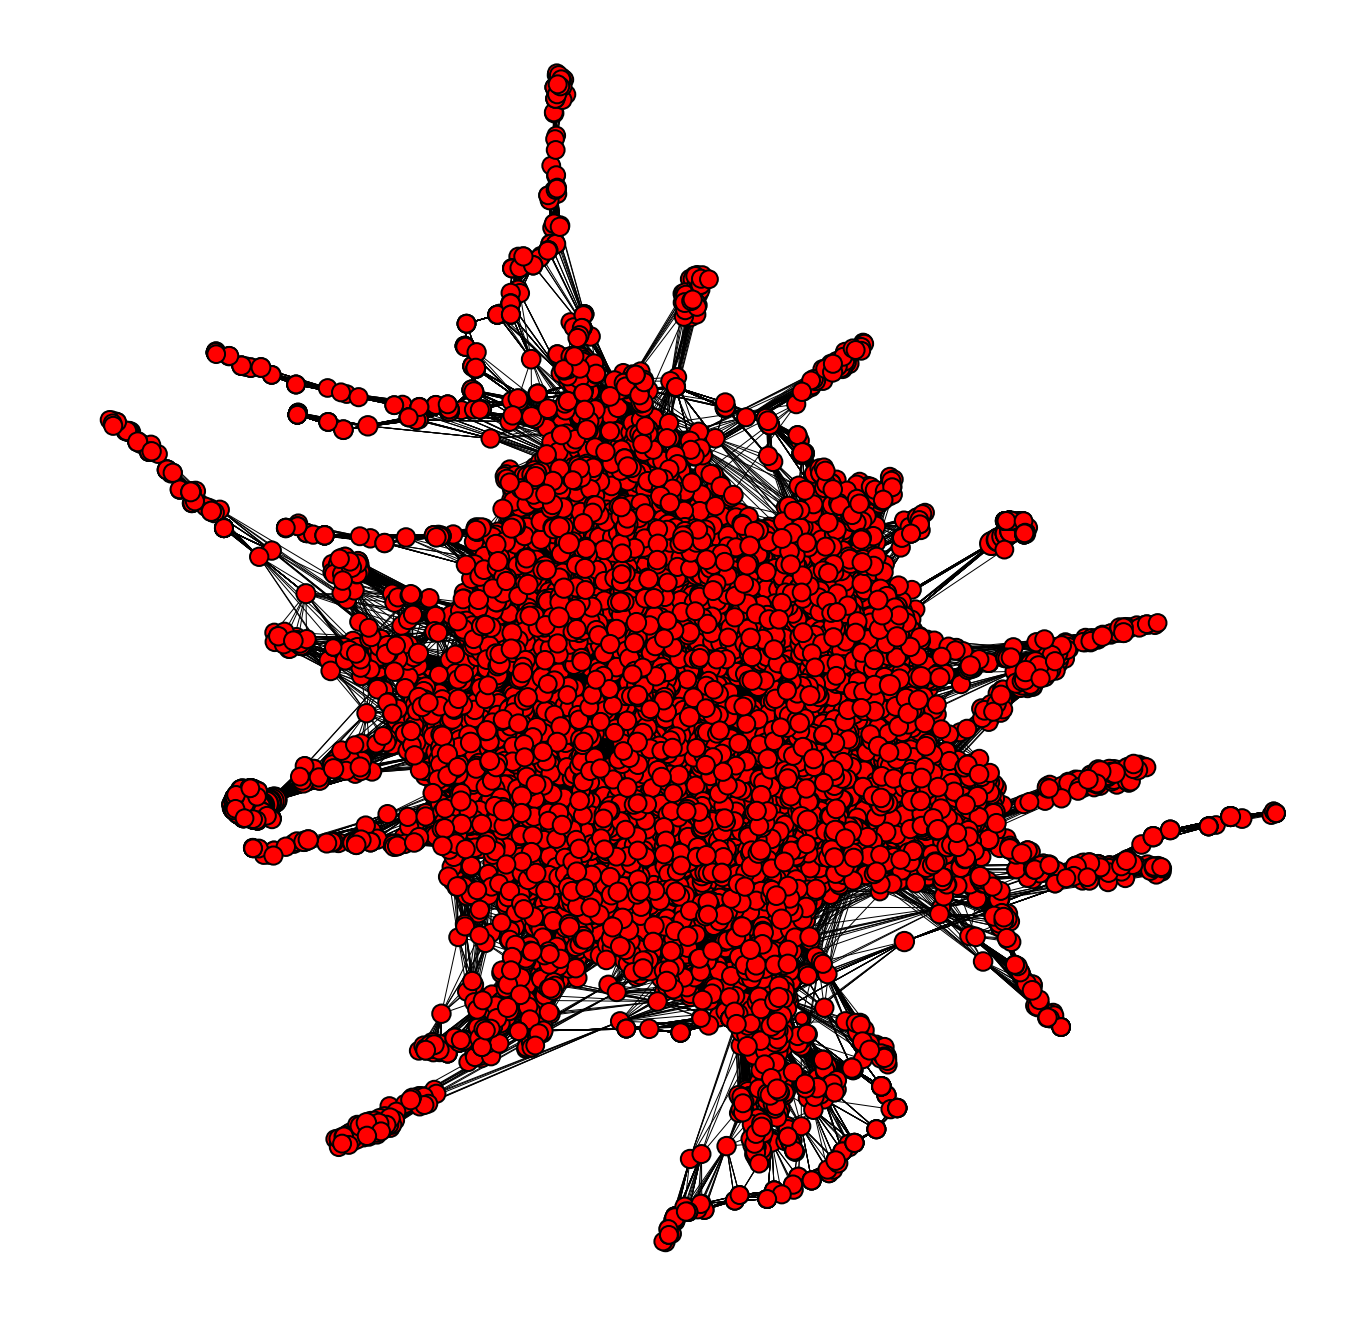

time elapsed: 228.33842420578003 seconds


In [39]:
# visualize network
start = time.time()
save_and_show_visualization(g, "politics.pdf")
end = time.time()
print('time elapsed: {} seconds'.format(end - start))

In [40]:
from numpy.linalg import eigvals
print(sorted(eigvals(nx.normalized_laplacian_matrix(g).A)))

[(-1.231653667943533e-16+0j), (0.0025527969500674305+0j), (0.002748854866849879+0j), (0.0035230708563922463+0j), (0.00445054194996476+0j), (0.0055095552242646235+0j), (0.006554867452428895+0j), (0.0069285596535400016+0j), (0.007315382962741146+0j), (0.008117103097618875+0j), (0.008677183929237789+0j), (0.009988259412172767+0j), (0.011180558884045393+0j), (0.014103684674772242+0j), (0.0157214994051462+0j), (0.016078467649657882+0j), (0.016800335743099824+0j), (0.017396622672891656+0j), (0.018128543642810017+0j), (0.019444672060142908+0j), (0.02055716553670689+0j), (0.021407599030361796+0j), (0.02166756065077284+0j), (0.023207663589974316+0j), (0.024244137201851826+0j), (0.025331384764101135+0j), (0.025665834221364196+0j), (0.026534270038024416+0j), (0.02924013094378436+0j), (0.03312965660751222+0j), (0.03506543415702199+0j), (0.035600628707993326+0j), (0.03574920061816346+0j), (0.03688741433760543+0j), (0.03815636381536673+0j), (0.03951490945632795+0j), (0.04070669819875335+0j), (0.0419

In [44]:
dict(g.degree()).values()

dict_values([26, 25, 30, 34, 32, 26, 38, 31, 38, 22, 26, 37, 24, 25, 27, 24, 25, 34, 38, 32, 31, 22, 32, 36, 28, 24, 30, 29, 29, 23, 31, 32, 22, 30, 33, 23, 29, 38, 26, 25, 27, 31, 22, 22, 52, 27, 37, 32, 34, 23, 24, 35, 31, 28, 28, 28, 29, 26, 31, 28, 25, 35, 32, 447, 31, 25, 35, 24, 32, 31, 28, 23, 25, 33, 23, 27, 38, 49, 26, 25, 24, 29, 29, 31, 25, 30, 25, 24, 36, 33, 29, 176, 30, 46, 32, 24, 24, 31, 27, 30, 23, 23, 40, 56, 27, 34, 446, 27, 28, 35, 24, 35, 32, 27, 28, 23, 38, 33, 25, 45, 30, 39, 42, 39, 30, 23, 23, 26, 31, 22, 30, 34, 26, 25, 26, 28, 23, 48, 23, 33, 36, 30, 24, 40, 38, 49, 25, 33, 29, 445, 27, 24, 29, 28, 23, 25, 24, 34, 37, 32, 24, 31, 23, 25, 30, 28, 443, 30, 28, 22, 27, 31, 23, 41, 27, 31, 28, 26, 31, 28, 26, 30, 441, 22, 30, 28, 29, 26, 30, 25, 38, 26, 28, 30, 32, 37, 35, 40, 36, 25, 25, 30, 26, 49, 26, 28, 22, 23, 37, 30, 26, 24, 34, 33, 24, 33, 176, 32, 27, 24, 36, 36, 25, 32, 43, 22, 32, 25, 23, 37, 33, 34, 26, 25, 31, 32, 25, 35, 176, 24, 47, 30, 34, 51, 34,